In this sheet I will apply Convolutional Neural Networks for stock prediction of Apple stock price. I will divide data from last 15 years into chunks. Every day contains one opening value. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 500
TEST_SIZE = 0.1
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True
PREDICTION_LABEL = 'Open'

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,10.284286,10.302857,10.092857,10.141429,8.779409,197810200
196,196,2006-02-28,10.225715,10.342857,9.728572,9.784286,8.470230,316745100
197,197,2006-03-01,9.834286,9.927143,9.717143,9.871428,8.545672,190954400
198,198,2006-03-02,9.855714,9.998571,9.810000,9.944285,8.608742,156318400


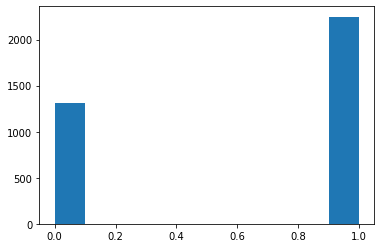

1    2248
0    1307
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[[PREDICTION_LABEL]].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3199, 200, 1), (3199,), (356, 200, 1), (356,))

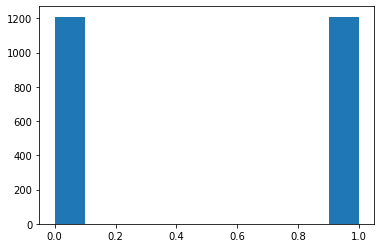

1.0    1209
0.0    1209
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 1), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binary-weights.h5')

Train on 2418 samples, validate on 356 samples
Epoch 1/500
2418/2418 [==============================] - 1s 434us/step - loss: 0.8057 - tp: 728.0000 - fp: 718.0000 - tn: 491.0000 - fn: 481.0000 - accuracy: 0.5041 - precision: 0.5035 - recall: 0.6022 - auc: 0.5080 - val_loss: 0.7062 - val_tp: 92.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 166.0000 - val_accuracy: 0.4831 - val_precision: 0.8364 - val_recall: 0.3566 - val_auc: 0.6121
Epoch 2/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.7414 - tp: 703.0000 - fp: 600.0000 - tn: 609.0000 - fn: 506.0000 - accuracy: 0.5426 - precision: 0.5395 - recall: 0.5815 - auc: 0.5536 - val_loss: 0.7092 - val_tp: 106.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 152.0000 - val_accuracy: 0.4860 - val_precision: 0.7737 - val_recall: 0.4109 - val_auc: 0.5941
Epoch 3/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.7208 - tp: 665.0000 - fp: 549.0000 - tn: 660.0000 - fn: 544.0000 - accuracy: 0.5480

Epoch 22/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.5757 - tp: 843.0000 - fp: 376.0000 - tn: 833.0000 - fn: 366.0000 - accuracy: 0.6931 - precision: 0.6916 - recall: 0.6973 - auc: 0.7664 - val_loss: 0.6997 - val_tp: 146.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 112.0000 - val_accuracy: 0.5955 - val_precision: 0.8202 - val_recall: 0.5659 - val_auc: 0.6561
Epoch 23/500
2418/2418 [==============================] - 0s 148us/step - loss: 0.5642 - tp: 864.0000 - fp: 354.0000 - tn: 855.0000 - fn: 345.0000 - accuracy: 0.7109 - precision: 0.7094 - recall: 0.7146 - auc: 0.7828 - val_loss: 0.6953 - val_tp: 106.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 152.0000 - val_accuracy: 0.5309 - val_precision: 0.8760 - val_recall: 0.4109 - val_auc: 0.7157
Epoch 24/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.5609 - tp: 838.0000 - fp: 343.0000 - tn: 866.0000 - fn: 371.0000 - accuracy: 0.7047 - precision: 0.7096 - recall: 0.6931 - auc

Epoch 43/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.4656 - tp: 933.0000 - fp: 253.0000 - tn: 956.0000 - fn: 276.0000 - accuracy: 0.7812 - precision: 0.7867 - recall: 0.7717 - auc: 0.8672 - val_loss: 0.7423 - val_tp: 135.0000 - val_fp: 33.0000 - val_tn: 65.0000 - val_fn: 123.0000 - val_accuracy: 0.5618 - val_precision: 0.8036 - val_recall: 0.5233 - val_auc: 0.6541
Epoch 44/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.4745 - tp: 948.0000 - fp: 278.0000 - tn: 931.0000 - fn: 261.0000 - accuracy: 0.7771 - precision: 0.7732 - recall: 0.7841 - auc: 0.8582 - val_loss: 0.7474 - val_tp: 124.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 134.0000 - val_accuracy: 0.5590 - val_precision: 0.8435 - val_recall: 0.4806 - val_auc: 0.7079
Epoch 45/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.4648 - tp: 930.0000 - fp: 264.0000 - tn: 945.0000 - fn: 279.0000 - accuracy: 0.7754 - precision: 0.7789 - recall: 0.7692 - auc

Epoch 64/500
2418/2418 [==============================] - 0s 150us/step - loss: 0.4011 - tp: 1002.0000 - fp: 211.0000 - tn: 998.0000 - fn: 207.0000 - accuracy: 0.8271 - precision: 0.8261 - recall: 0.8288 - auc: 0.9054 - val_loss: 0.7342 - val_tp: 133.0000 - val_fp: 30.0000 - val_tn: 68.0000 - val_fn: 125.0000 - val_accuracy: 0.5646 - val_precision: 0.8160 - val_recall: 0.5155 - val_auc: 0.6933
Epoch 65/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.3933 - tp: 997.0000 - fp: 197.0000 - tn: 1012.0000 - fn: 212.0000 - accuracy: 0.8309 - precision: 0.8350 - recall: 0.8246 - auc: 0.9101 - val_loss: 0.7748 - val_tp: 109.0000 - val_fp: 13.0000 - val_tn: 85.0000 - val_fn: 149.0000 - val_accuracy: 0.5449 - val_precision: 0.8934 - val_recall: 0.4225 - val_auc: 0.7396
Epoch 66/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.3960 - tp: 994.0000 - fp: 196.0000 - tn: 1013.0000 - fn: 215.0000 - accuracy: 0.8300 - precision: 0.8353 - recall: 0.8222 - 

Epoch 85/500
2418/2418 [==============================] - 0s 144us/step - loss: 0.3459 - tp: 1032.0000 - fp: 178.0000 - tn: 1031.0000 - fn: 177.0000 - accuracy: 0.8532 - precision: 0.8529 - recall: 0.8536 - auc: 0.9328 - val_loss: 0.8031 - val_tp: 108.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 150.0000 - val_accuracy: 0.5365 - val_precision: 0.8780 - val_recall: 0.4186 - val_auc: 0.7691
Epoch 86/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.3316 - tp: 1037.0000 - fp: 161.0000 - tn: 1048.0000 - fn: 172.0000 - accuracy: 0.8623 - precision: 0.8656 - recall: 0.8577 - auc: 0.9405 - val_loss: 0.8206 - val_tp: 114.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 144.0000 - val_accuracy: 0.5478 - val_precision: 0.8702 - val_recall: 0.4419 - val_auc: 0.7281
Epoch 87/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.3363 - tp: 1044.0000 - fp: 160.0000 - tn: 1049.0000 - fn: 165.0000 - accuracy: 0.8656 - precision: 0.8671 - recall: 0.8635

Epoch 106/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.2985 - tp: 1078.0000 - fp: 151.0000 - tn: 1058.0000 - fn: 131.0000 - accuracy: 0.8834 - precision: 0.8771 - recall: 0.8916 - auc: 0.9505 - val_loss: 0.8768 - val_tp: 115.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 143.0000 - val_accuracy: 0.5590 - val_precision: 0.8915 - val_recall: 0.4457 - val_auc: 0.7380
Epoch 107/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.2891 - tp: 1070.0000 - fp: 135.0000 - tn: 1074.0000 - fn: 139.0000 - accuracy: 0.8867 - precision: 0.8880 - recall: 0.8850 - auc: 0.9557 - val_loss: 0.8997 - val_tp: 101.0000 - val_fp: 6.0000 - val_tn: 92.0000 - val_fn: 157.0000 - val_accuracy: 0.5421 - val_precision: 0.9439 - val_recall: 0.3915 - val_auc: 0.7652
Epoch 108/500
2418/2418 [==============================] - 0s 146us/step - loss: 0.2913 - tp: 1073.0000 - fp: 133.0000 - tn: 1076.0000 - fn: 136.0000 - accuracy: 0.8888 - precision: 0.8897 - recall: 0.88

Epoch 127/500
2418/2418 [==============================] - 0s 138us/step - loss: 0.2562 - tp: 1080.0000 - fp: 105.0000 - tn: 1104.0000 - fn: 129.0000 - accuracy: 0.9032 - precision: 0.9114 - recall: 0.8933 - auc: 0.9656 - val_loss: 0.7848 - val_tp: 133.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 125.0000 - val_accuracy: 0.5787 - val_precision: 0.8418 - val_recall: 0.5155 - val_auc: 0.7063
Epoch 128/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.2572 - tp: 1079.0000 - fp: 119.0000 - tn: 1090.0000 - fn: 130.0000 - accuracy: 0.8970 - precision: 0.9007 - recall: 0.8925 - auc: 0.9648 - val_loss: 0.7739 - val_tp: 136.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 122.0000 - val_accuracy: 0.6152 - val_precision: 0.9007 - val_recall: 0.5271 - val_auc: 0.7726
Epoch 129/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.2623 - tp: 1077.0000 - fp: 117.0000 - tn: 1092.0000 - fn: 132.0000 - accuracy: 0.8970 - precision: 0.9020 - recall: 0.8

Epoch 148/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.2435 - tp: 1087.0000 - fp: 107.0000 - tn: 1102.0000 - fn: 122.0000 - accuracy: 0.9053 - precision: 0.9104 - recall: 0.8991 - auc: 0.9666 - val_loss: 0.8380 - val_tp: 139.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 119.0000 - val_accuracy: 0.5758 - val_precision: 0.8129 - val_recall: 0.5388 - val_auc: 0.6987
Epoch 149/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.2399 - tp: 1099.0000 - fp: 116.0000 - tn: 1093.0000 - fn: 110.0000 - accuracy: 0.9065 - precision: 0.9045 - recall: 0.9090 - auc: 0.9685 - val_loss: 0.7596 - val_tp: 133.0000 - val_fp: 13.0000 - val_tn: 85.0000 - val_fn: 125.0000 - val_accuracy: 0.6124 - val_precision: 0.9110 - val_recall: 0.5155 - val_auc: 0.7865
Epoch 150/500
2418/2418 [==============================] - 0s 150us/step - loss: 0.2190 - tp: 1121.0000 - fp: 99.0000 - tn: 1110.0000 - fn: 88.0000 - accuracy: 0.9227 - precision: 0.9189 - recall: 0.927

Epoch 169/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.2144 - tp: 1118.0000 - fp: 95.0000 - tn: 1114.0000 - fn: 91.0000 - accuracy: 0.9231 - precision: 0.9217 - recall: 0.9247 - auc: 0.9752 - val_loss: 0.8251 - val_tp: 151.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 107.0000 - val_accuracy: 0.6433 - val_precision: 0.8830 - val_recall: 0.5853 - val_auc: 0.7281
Epoch 170/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.2005 - tp: 1108.0000 - fp: 83.0000 - tn: 1126.0000 - fn: 101.0000 - accuracy: 0.9239 - precision: 0.9303 - recall: 0.9165 - auc: 0.9794 - val_loss: 0.7766 - val_tp: 148.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 110.0000 - val_accuracy: 0.6404 - val_precision: 0.8916 - val_recall: 0.5736 - val_auc: 0.7609
Epoch 171/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.2058 - tp: 1107.0000 - fp: 98.0000 - tn: 1111.0000 - fn: 102.0000 - accuracy: 0.9173 - precision: 0.9187 - recall: 0.9156 

Epoch 190/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.1949 - tp: 1109.0000 - fp: 74.0000 - tn: 1135.0000 - fn: 100.0000 - accuracy: 0.9280 - precision: 0.9374 - recall: 0.9173 - auc: 0.9792 - val_loss: 0.8955 - val_tp: 137.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 121.0000 - val_accuracy: 0.6067 - val_precision: 0.8782 - val_recall: 0.5310 - val_auc: 0.7362
Epoch 191/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.1901 - tp: 1131.0000 - fp: 76.0000 - tn: 1133.0000 - fn: 78.0000 - accuracy: 0.9363 - precision: 0.9370 - recall: 0.9355 - auc: 0.9806 - val_loss: 0.8951 - val_tp: 130.0000 - val_fp: 13.0000 - val_tn: 85.0000 - val_fn: 128.0000 - val_accuracy: 0.6039 - val_precision: 0.9091 - val_recall: 0.5039 - val_auc: 0.7564
Epoch 192/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.1807 - tp: 1127.0000 - fp: 82.0000 - tn: 1127.0000 - fn: 82.0000 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 -

Epoch 211/500
2418/2418 [==============================] - 0s 155us/step - loss: 0.1653 - tp: 1130.0000 - fp: 76.0000 - tn: 1133.0000 - fn: 79.0000 - accuracy: 0.9359 - precision: 0.9370 - recall: 0.9347 - auc: 0.9863 - val_loss: 0.9442 - val_tp: 138.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 120.0000 - val_accuracy: 0.6096 - val_precision: 0.8790 - val_recall: 0.5349 - val_auc: 0.7412
Epoch 212/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.1769 - tp: 1125.0000 - fp: 73.0000 - tn: 1136.0000 - fn: 84.0000 - accuracy: 0.9351 - precision: 0.9391 - recall: 0.9305 - auc: 0.9827 - val_loss: 1.0033 - val_tp: 118.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 140.0000 - val_accuracy: 0.5730 - val_precision: 0.9077 - val_recall: 0.4574 - val_auc: 0.7514
Epoch 213/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.1766 - tp: 1135.0000 - fp: 78.0000 - tn: 1131.0000 - fn: 74.0000 - accuracy: 0.9371 - precision: 0.9357 - recall: 0.9388 - 

Epoch 232/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.1680 - tp: 1143.0000 - fp: 79.0000 - tn: 1130.0000 - fn: 66.0000 - accuracy: 0.9400 - precision: 0.9354 - recall: 0.9454 - auc: 0.9849 - val_loss: 0.9073 - val_tp: 132.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 126.0000 - val_accuracy: 0.6124 - val_precision: 0.9167 - val_recall: 0.5116 - val_auc: 0.7732
Epoch 233/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.1531 - tp: 1139.0000 - fp: 72.0000 - tn: 1137.0000 - fn: 70.0000 - accuracy: 0.9413 - precision: 0.9405 - recall: 0.9421 - auc: 0.9881 - val_loss: 0.7514 - val_tp: 159.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 99.0000 - val_accuracy: 0.6601 - val_precision: 0.8785 - val_recall: 0.6163 - val_auc: 0.7735
Epoch 234/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.1621 - tp: 1134.0000 - fp: 76.0000 - tn: 1133.0000 - fn: 75.0000 - accuracy: 0.9376 - precision: 0.9372 - recall: 0.9380 - a

Epoch 253/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.1377 - tp: 1157.0000 - fp: 54.0000 - tn: 1155.0000 - fn: 52.0000 - accuracy: 0.9562 - precision: 0.9554 - recall: 0.9570 - auc: 0.9909 - val_loss: 1.0089 - val_tp: 126.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 132.0000 - val_accuracy: 0.5983 - val_precision: 0.9197 - val_recall: 0.4884 - val_auc: 0.7524
Epoch 254/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.1466 - tp: 1132.0000 - fp: 53.0000 - tn: 1156.0000 - fn: 77.0000 - accuracy: 0.9462 - precision: 0.9553 - recall: 0.9363 - auc: 0.9892 - val_loss: 0.9935 - val_tp: 120.0000 - val_fp: 8.0000 - val_tn: 90.0000 - val_fn: 138.0000 - val_accuracy: 0.5899 - val_precision: 0.9375 - val_recall: 0.4651 - val_auc: 0.8002
Epoch 255/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1399 - tp: 1142.0000 - fp: 56.0000 - tn: 1153.0000 - fn: 67.0000 - accuracy: 0.9491 - precision: 0.9533 - recall: 0.9446 - a

Epoch 274/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1430 - tp: 1153.0000 - fp: 64.0000 - tn: 1145.0000 - fn: 56.0000 - accuracy: 0.9504 - precision: 0.9474 - recall: 0.9537 - auc: 0.9884 - val_loss: 0.9867 - val_tp: 136.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 122.0000 - val_accuracy: 0.6096 - val_precision: 0.8889 - val_recall: 0.5271 - val_auc: 0.7431
Epoch 275/500
2418/2418 [==============================] - 0s 138us/step - loss: 0.1396 - tp: 1143.0000 - fp: 62.0000 - tn: 1147.0000 - fn: 66.0000 - accuracy: 0.9471 - precision: 0.9485 - recall: 0.9454 - auc: 0.9893 - val_loss: 0.8804 - val_tp: 150.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 108.0000 - val_accuracy: 0.6348 - val_precision: 0.8721 - val_recall: 0.5814 - val_auc: 0.7499
Epoch 276/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1279 - tp: 1154.0000 - fp: 60.0000 - tn: 1149.0000 - fn: 55.0000 - accuracy: 0.9524 - precision: 0.9506 - recall: 0.9545 - 

Epoch 295/500
2418/2418 [==============================] - 0s 138us/step - loss: 0.1240 - tp: 1164.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 45.0000 - accuracy: 0.9624 - precision: 0.9620 - recall: 0.9628 - auc: 0.9925 - val_loss: 0.9341 - val_tp: 140.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 118.0000 - val_accuracy: 0.6152 - val_precision: 0.8805 - val_recall: 0.5426 - val_auc: 0.7547
Epoch 296/500
2418/2418 [==============================] - 0s 138us/step - loss: 0.1222 - tp: 1152.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 57.0000 - accuracy: 0.9586 - precision: 0.9640 - recall: 0.9529 - auc: 0.9924 - val_loss: 0.9969 - val_tp: 151.0000 - val_fp: 24.0000 - val_tn: 74.0000 - val_fn: 107.0000 - val_accuracy: 0.6320 - val_precision: 0.8629 - val_recall: 0.5853 - val_auc: 0.7379
Epoch 297/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1262 - tp: 1149.0000 - fp: 53.0000 - tn: 1156.0000 - fn: 60.0000 - accuracy: 0.9533 - precision: 0.9559 - recall: 0.9504 - 

Epoch 316/500
2418/2418 [==============================] - 0s 141us/step - loss: 0.1109 - tp: 1155.0000 - fp: 44.0000 - tn: 1165.0000 - fn: 54.0000 - accuracy: 0.9595 - precision: 0.9633 - recall: 0.9553 - auc: 0.9937 - val_loss: 0.9030 - val_tp: 153.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 105.0000 - val_accuracy: 0.6348 - val_precision: 0.8596 - val_recall: 0.5930 - val_auc: 0.7278
Epoch 317/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.1274 - tp: 1145.0000 - fp: 55.0000 - tn: 1154.0000 - fn: 64.0000 - accuracy: 0.9508 - precision: 0.9542 - recall: 0.9471 - auc: 0.9909 - val_loss: 0.9030 - val_tp: 142.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 116.0000 - val_accuracy: 0.6348 - val_precision: 0.9103 - val_recall: 0.5504 - val_auc: 0.7848
Epoch 318/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.1096 - tp: 1166.0000 - fp: 52.0000 - tn: 1157.0000 - fn: 43.0000 - accuracy: 0.9607 - precision: 0.9573 - recall: 0.9644 - 

Epoch 337/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.1112 - tp: 1163.0000 - fp: 57.0000 - tn: 1152.0000 - fn: 46.0000 - accuracy: 0.9574 - precision: 0.9533 - recall: 0.9620 - auc: 0.9937 - val_loss: 0.9053 - val_tp: 152.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 106.0000 - val_accuracy: 0.6545 - val_precision: 0.8994 - val_recall: 0.5891 - val_auc: 0.7848
Epoch 338/500
2418/2418 [==============================] - 0s 138us/step - loss: 0.1064 - tp: 1165.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 44.0000 - accuracy: 0.9644 - precision: 0.9652 - recall: 0.9636 - auc: 0.9941 - val_loss: 0.9855 - val_tp: 135.0000 - val_fp: 13.0000 - val_tn: 85.0000 - val_fn: 123.0000 - val_accuracy: 0.6180 - val_precision: 0.9122 - val_recall: 0.5233 - val_auc: 0.7621
Epoch 339/500
2418/2418 [==============================] - 0s 137us/step - loss: 0.1078 - tp: 1166.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 43.0000 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - 

Epoch 358/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.0910 - tp: 1167.0000 - fp: 33.0000 - tn: 1176.0000 - fn: 42.0000 - accuracy: 0.9690 - precision: 0.9725 - recall: 0.9653 - auc: 0.9964 - val_loss: 1.0420 - val_tp: 137.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 121.0000 - val_accuracy: 0.6152 - val_precision: 0.8954 - val_recall: 0.5310 - val_auc: 0.7632
Epoch 359/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1072 - tp: 1152.0000 - fp: 41.0000 - tn: 1168.0000 - fn: 57.0000 - accuracy: 0.9595 - precision: 0.9656 - recall: 0.9529 - auc: 0.9938 - val_loss: 1.0395 - val_tp: 131.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 127.0000 - val_accuracy: 0.6011 - val_precision: 0.8973 - val_recall: 0.5078 - val_auc: 0.7724
Epoch 360/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0991 - tp: 1169.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 40.0000 - accuracy: 0.9661 - precision: 0.9653 - recall: 0.9669 - 

Epoch 379/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.0897 - tp: 1173.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 36.0000 - accuracy: 0.9677 - precision: 0.9654 - recall: 0.9702 - auc: 0.9961 - val_loss: 1.1807 - val_tp: 123.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 135.0000 - val_accuracy: 0.5899 - val_precision: 0.9179 - val_recall: 0.4767 - val_auc: 0.7453
Epoch 380/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.1117 - tp: 1156.0000 - fp: 56.0000 - tn: 1153.0000 - fn: 53.0000 - accuracy: 0.9549 - precision: 0.9538 - recall: 0.9562 - auc: 0.9929 - val_loss: 0.9766 - val_tp: 151.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 107.0000 - val_accuracy: 0.6404 - val_precision: 0.8779 - val_recall: 0.5853 - val_auc: 0.7425
Epoch 381/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.1159 - tp: 1158.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 51.0000 - accuracy: 0.9603 - precision: 0.9626 - recall: 0.9578 - 

Epoch 400/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.0957 - tp: 1166.0000 - fp: 35.0000 - tn: 1174.0000 - fn: 43.0000 - accuracy: 0.9677 - precision: 0.9709 - recall: 0.9644 - auc: 0.9949 - val_loss: 1.0112 - val_tp: 154.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 104.0000 - val_accuracy: 0.6461 - val_precision: 0.8750 - val_recall: 0.5969 - val_auc: 0.7327
Epoch 401/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.0811 - tp: 1177.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 32.0000 - accuracy: 0.9739 - precision: 0.9743 - recall: 0.9735 - auc: 0.9971 - val_loss: 0.9723 - val_tp: 136.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 122.0000 - val_accuracy: 0.6096 - val_precision: 0.8889 - val_recall: 0.5271 - val_auc: 0.7593
Epoch 402/500
2418/2418 [==============================] - 0s 144us/step - loss: 0.0989 - tp: 1171.0000 - fp: 40.0000 - tn: 1169.0000 - fn: 38.0000 - accuracy: 0.9677 - precision: 0.9670 - recall: 0.9686 - 

Epoch 421/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.0892 - tp: 1169.0000 - fp: 30.0000 - tn: 1179.0000 - fn: 40.0000 - accuracy: 0.9711 - precision: 0.9750 - recall: 0.9669 - auc: 0.9960 - val_loss: 1.0730 - val_tp: 130.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 128.0000 - val_accuracy: 0.6011 - val_precision: 0.9028 - val_recall: 0.5039 - val_auc: 0.7528
Epoch 422/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0879 - tp: 1180.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 29.0000 - accuracy: 0.9702 - precision: 0.9648 - recall: 0.9760 - auc: 0.9963 - val_loss: 1.0911 - val_tp: 138.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 120.0000 - val_accuracy: 0.6067 - val_precision: 0.8734 - val_recall: 0.5349 - val_auc: 0.7356
Epoch 423/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0879 - tp: 1173.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 36.0000 - accuracy: 0.9719 - precision: 0.9734 - recall: 0.9702 - 

Epoch 442/500
2418/2418 [==============================] - 0s 146us/step - loss: 0.0899 - tp: 1167.0000 - fp: 38.0000 - tn: 1171.0000 - fn: 42.0000 - accuracy: 0.9669 - precision: 0.9685 - recall: 0.9653 - auc: 0.9957 - val_loss: 1.0931 - val_tp: 140.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 118.0000 - val_accuracy: 0.6236 - val_precision: 0.8974 - val_recall: 0.5426 - val_auc: 0.7664
Epoch 443/500
2418/2418 [==============================] - 0s 144us/step - loss: 0.0842 - tp: 1174.0000 - fp: 38.0000 - tn: 1171.0000 - fn: 35.0000 - accuracy: 0.9698 - precision: 0.9686 - recall: 0.9711 - auc: 0.9961 - val_loss: 1.0375 - val_tp: 146.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 112.0000 - val_accuracy: 0.6433 - val_precision: 0.9068 - val_recall: 0.5659 - val_auc: 0.7646
Epoch 444/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0903 - tp: 1165.0000 - fp: 35.0000 - tn: 1174.0000 - fn: 44.0000 - accuracy: 0.9673 - precision: 0.9708 - recall: 0.9636 - 

Epoch 463/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.0751 - tp: 1176.0000 - fp: 28.0000 - tn: 1181.0000 - fn: 33.0000 - accuracy: 0.9748 - precision: 0.9767 - recall: 0.9727 - auc: 0.9971 - val_loss: 0.9640 - val_tp: 150.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 108.0000 - val_accuracy: 0.6545 - val_precision: 0.9091 - val_recall: 0.5814 - val_auc: 0.7638
Epoch 464/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.0880 - tp: 1172.0000 - fp: 41.0000 - tn: 1168.0000 - fn: 37.0000 - accuracy: 0.9677 - precision: 0.9662 - recall: 0.9694 - auc: 0.9959 - val_loss: 1.1359 - val_tp: 138.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 120.0000 - val_accuracy: 0.6180 - val_precision: 0.8961 - val_recall: 0.5349 - val_auc: 0.7448
Epoch 465/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.0842 - tp: 1177.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 32.0000 - accuracy: 0.9739 - precision: 0.9743 - recall: 0.9735 - 

Epoch 484/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.0756 - tp: 1185.0000 - fp: 36.0000 - tn: 1173.0000 - fn: 24.0000 - accuracy: 0.9752 - precision: 0.9705 - recall: 0.9801 - auc: 0.9970 - val_loss: 1.1871 - val_tp: 135.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 123.0000 - val_accuracy: 0.6096 - val_precision: 0.8940 - val_recall: 0.5233 - val_auc: 0.7302
Epoch 485/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.0874 - tp: 1175.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 34.0000 - accuracy: 0.9727 - precision: 0.9735 - recall: 0.9719 - auc: 0.9955 - val_loss: 1.1786 - val_tp: 135.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 123.0000 - val_accuracy: 0.6236 - val_precision: 0.9247 - val_recall: 0.5233 - val_auc: 0.7484
Epoch 486/500
2418/2418 [==============================] - 0s 139us/step - loss: 0.0717 - tp: 1182.0000 - fp: 27.0000 - tn: 1182.0000 - fn: 27.0000 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - 

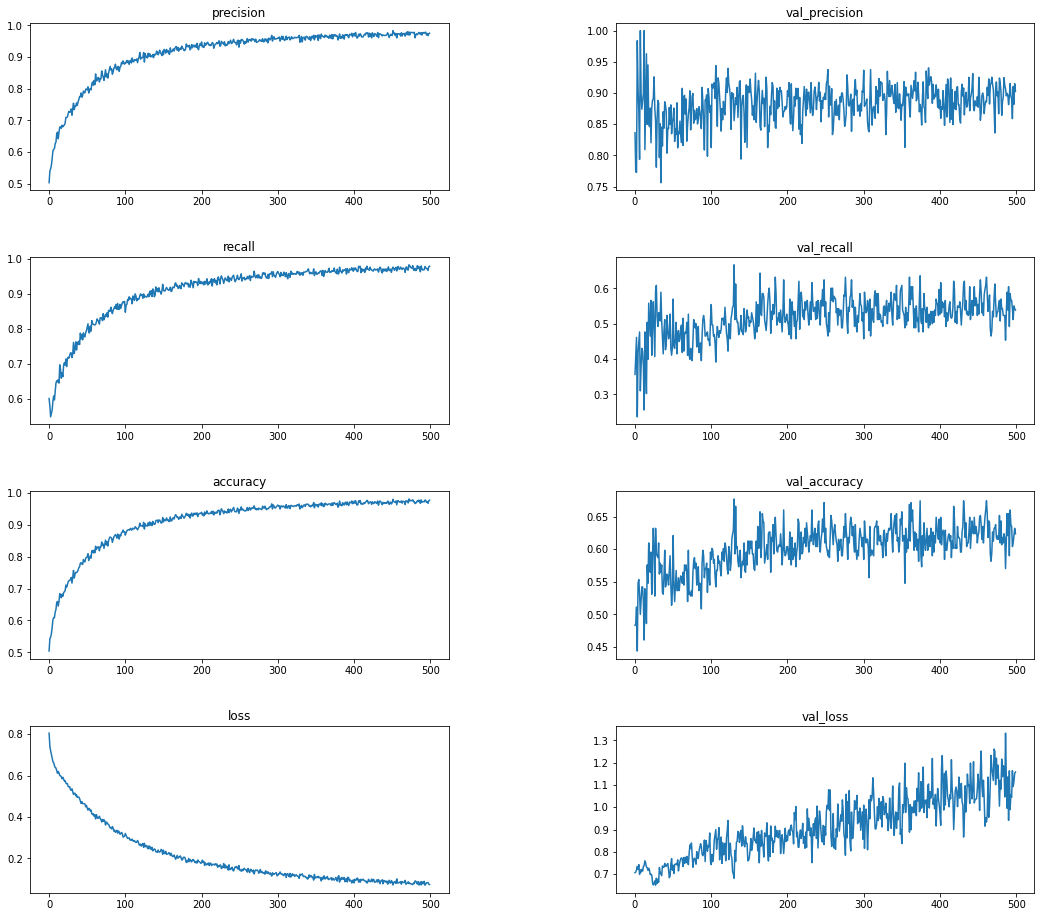

In [12]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy', 'loss']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()

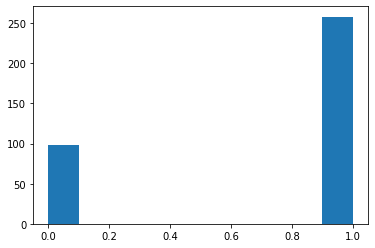

1.0    258
0.0     98
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**FEATURE VISUALIZATION** Now, as the model is ready, lets try to explain it a little.

In [14]:
from keras.models import Model

model_viz = Model(inputs=model.inputs, outputs=[model.layers[i].output for i in [0, 4]])
model_viz.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 200, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
Total params: 808
Trainable params: 776
Non-trainable params: 32
____________________________________________________________

Sample Label:  1.0
Prediction:  [[0.9975241]]


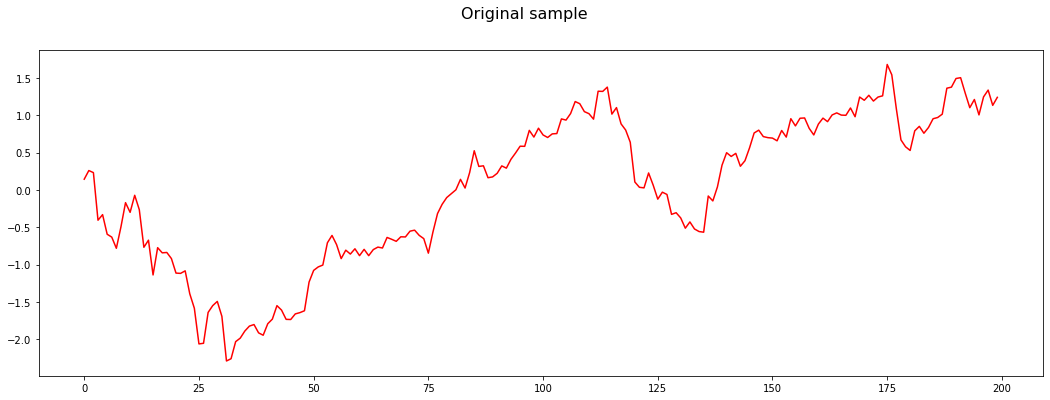

(5, 1, 16)


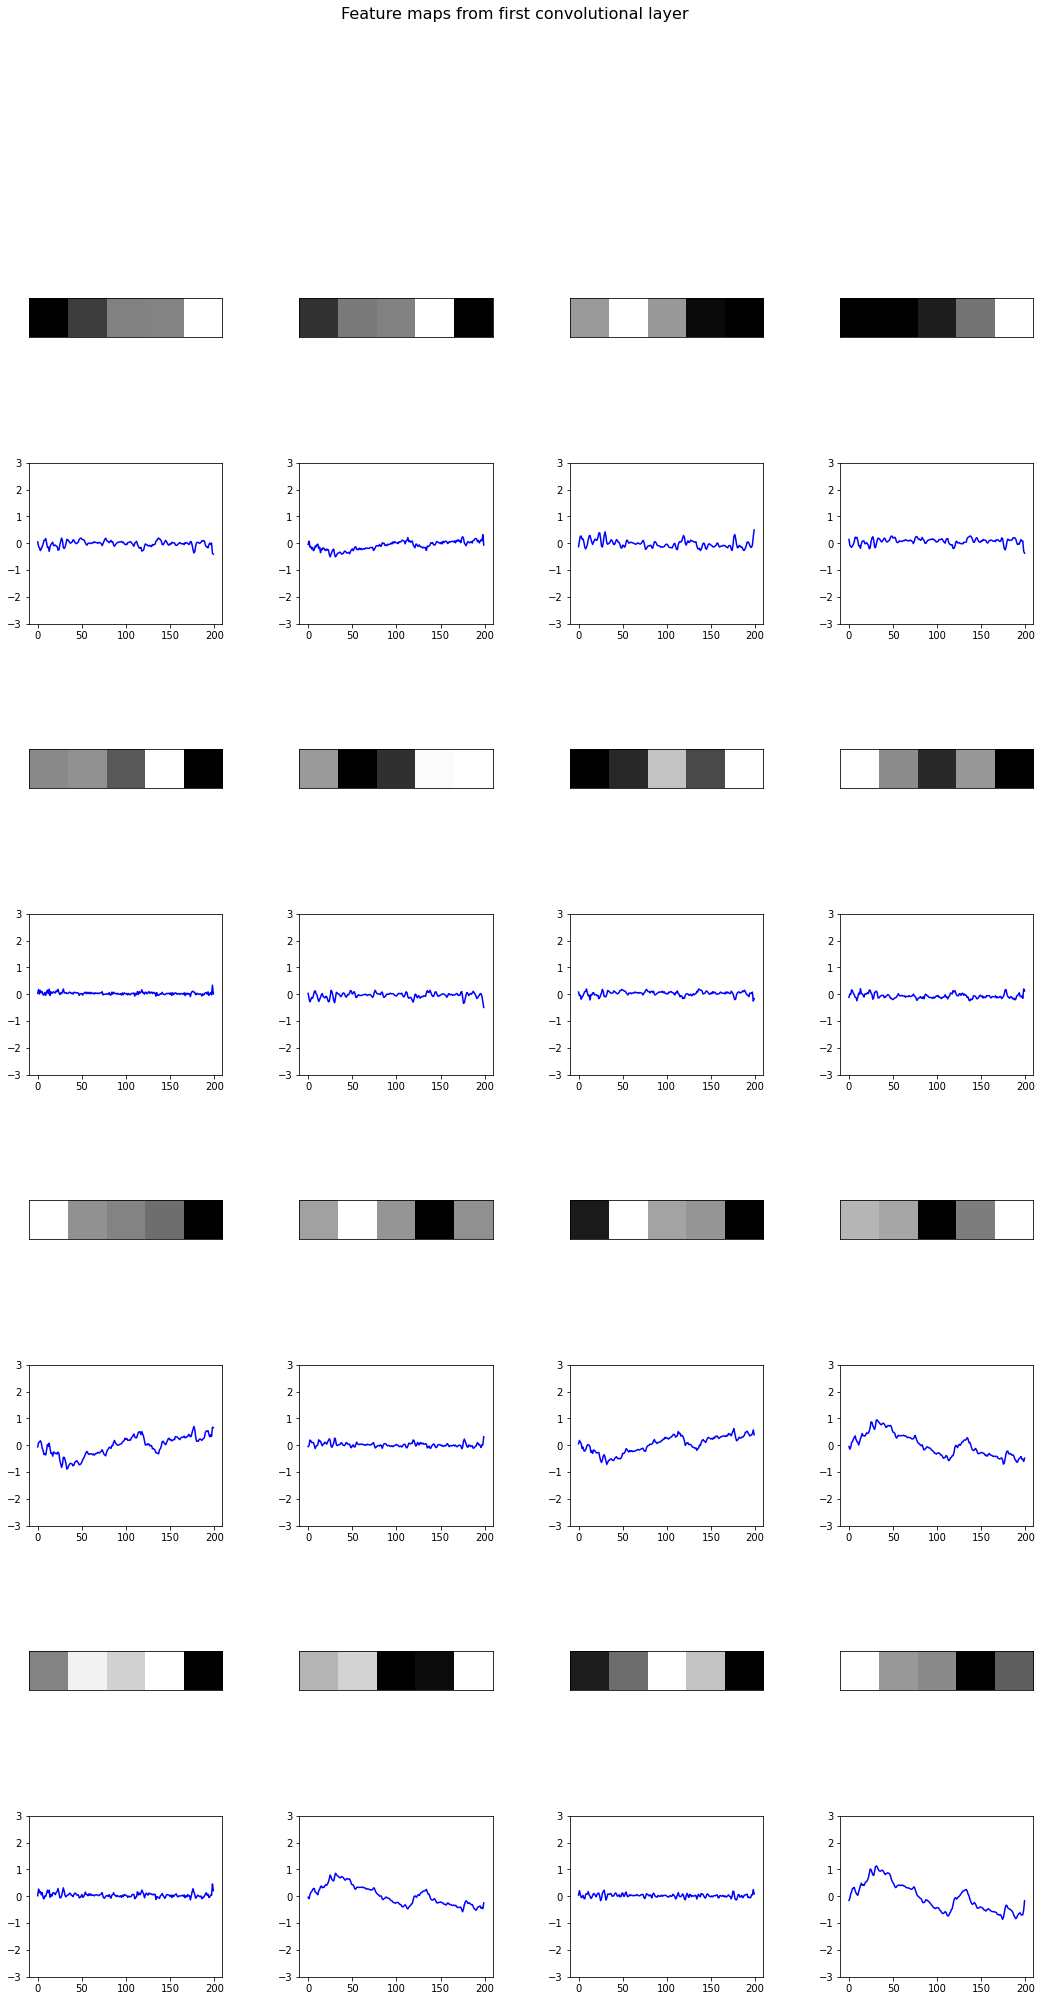

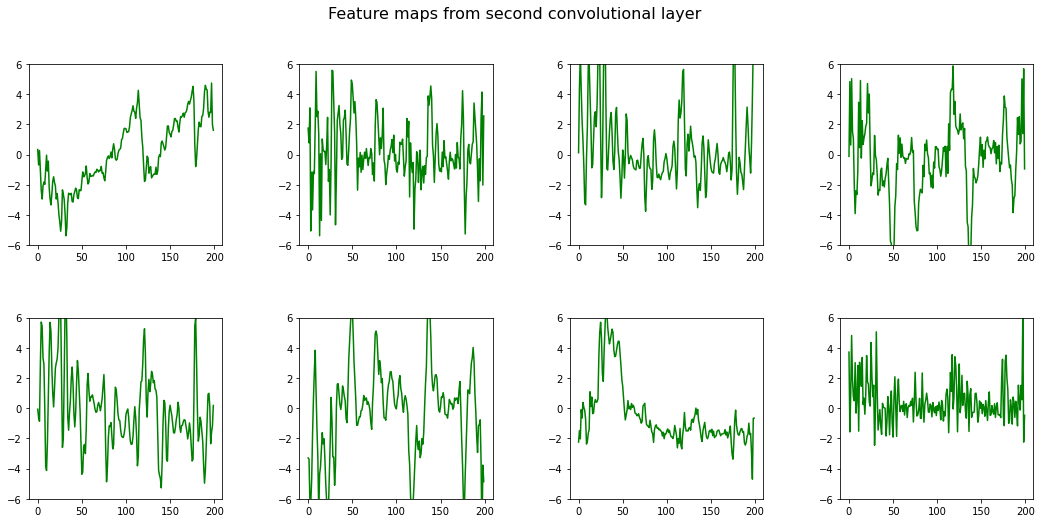

In [26]:
sample_no = 200

sample = X_test[sample_no]
sample_Y = Y_test[sample_no]
print("Sample Label: ", sample_Y)
print("Prediction: ", model.predict(np.array([sample])))

fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Original sample', fontsize=16)
plt.plot(sample, 'r-')
plt.show()

prediction = model_viz.predict(np.array([sample]))

filters1, _ = model.layers[0].get_weights()
filters2, _ = model.layers[4].get_weights()

print(filters1.shape)

square = 4
idx = 1
featuremap_idx = 0
filter_idx = 0

fig = plt.figure(figsize=(18, 32))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from first convolutional layer', fontsize=16)
    
for col in range(2*square):
    for row in range(square):
        if col % 2 == 0:
            ax = plt.subplot(2*square, square, idx)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(np.transpose(filters1[:, :, filter_idx]), cmap='gray')
            filter_idx += 1
        else:
            ax = plt.subplot(2*square, square, idx)
            ax.set_ylim((-3,3))
            plt.plot(prediction[0][:,:,featuremap_idx][0], 'b-')
            featuremap_idx += 1
        idx += 1

plt.show()

idx = 1

fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from second convolutional layer', fontsize=16)
    
for _ in range(2):
    for _ in range(4):
        ax = plt.subplot(2, 4, idx)
        ax.set_ylim((-6,6))
        plt.plot(prediction[1][:,:,idx-1][0], 'g-')
        idx += 1

plt.show()